In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
from scipy import ndimage


In [3]:
import warnings

warnings.filterwarnings('ignore') #too many warnings (DataFrame.swapaxes is deprecated and will be removed in a future version)

col_names=['ch1','ch2','ch3','ch4']
gesture_names = ['Rest','Extension','Flexion','Ulnar Deviation','Radial Deviation','Grip','Abduction of Fingers','Adduction of Fingers','Supination','Pronation']

for i in range(40): #data1 to data40
    globals()['data{}'.format(i+1)] = pd.read_csv('/Users/jhr/workspace/GitHub/EMG_data_analysis/Dataset for multi-channel surface electromyography (sEMG) signals of hand gestures/sEMG-dataset/raw/csv/{}_raw.csv'.format(i+1), names=col_names)

    globals()['data{}_pattern'.format(i+1)] = [globals()['data{}'.format(i+1)][r:r + 268000] for r in range(0, len(globals()['data{}'.format(i+1)]), 268000)] #divide the data by 268000 steps at a time

    for f in col_names: #ch1 to ch4
        
        for j in range(5): #pattern1 to pattern5
            
            for g in range(10): #gesture1 to gesture10
                if g == 0: #make a dataframe what sets the standard index
                    globals()['data{}_gestures{}'.format(i+1,j+1)] = np.array_split(globals()['data{}_pattern'.format(i+1)][j].iloc[4000:204000], 10) #split the data into 10 gestures
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]) #new dataframe to set columns as gestures

                else: #appending the other features by pd.concat
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)] = pd.concat([globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)],pd.DataFrame(globals()['data{}_gestures{}'.format(i+1,j+1)][g][f]).set_index(globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].index)],axis=1,join='inner')
                    globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index

                    #globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)] = globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].iloc[2000:18000] #new dataframe with a little of the rest time(0:4000, 16000:20000)
                    #globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].reset_index(drop=True, inplace=True) #reset the index
            
            globals()['data{}_{}_gestures{}'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names
            #globals()['data{}_{}_gestures{}_litre'.format(i+1,f,j+1)].columns = gesture_names #rename the columns by the exact gesture names 


Apply Filters to smooth signal

In [12]:
def median(raw, box_size, mode='nearest'): # Median Filter
    raw_median=ndimage.median_filter(raw,box_size,mode=mode)
    return raw_median.real

def maximum(raw, box_size, mode='nearest'): # Maximum Filter
    raw_maximum=ndimage.maximum_filter(raw,box_size,mode=mode)
    return raw_maximum.real

def denoise_fft(data, ifftn): # Fast Fourier Transformation
    fft_signal = np.fft.fft(data)#.values) # Fast Fourier Transformation 
    
    # Reconstruct the original signal
    fft_signal[ifftn:len(fft_signal)//2]=0
    fft_signal[len(fft_signal)//2:-ifftn]=0
    reconstructed_signal = np.fft.ifft(fft_signal)
    
    return reconstructed_signal.real

def smooth(x,beta): # Kaiser Window Smoothing
    window_len=11  # extending the data at beginning and at the end to apply the window at the borders

    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[5:len(y)-5]

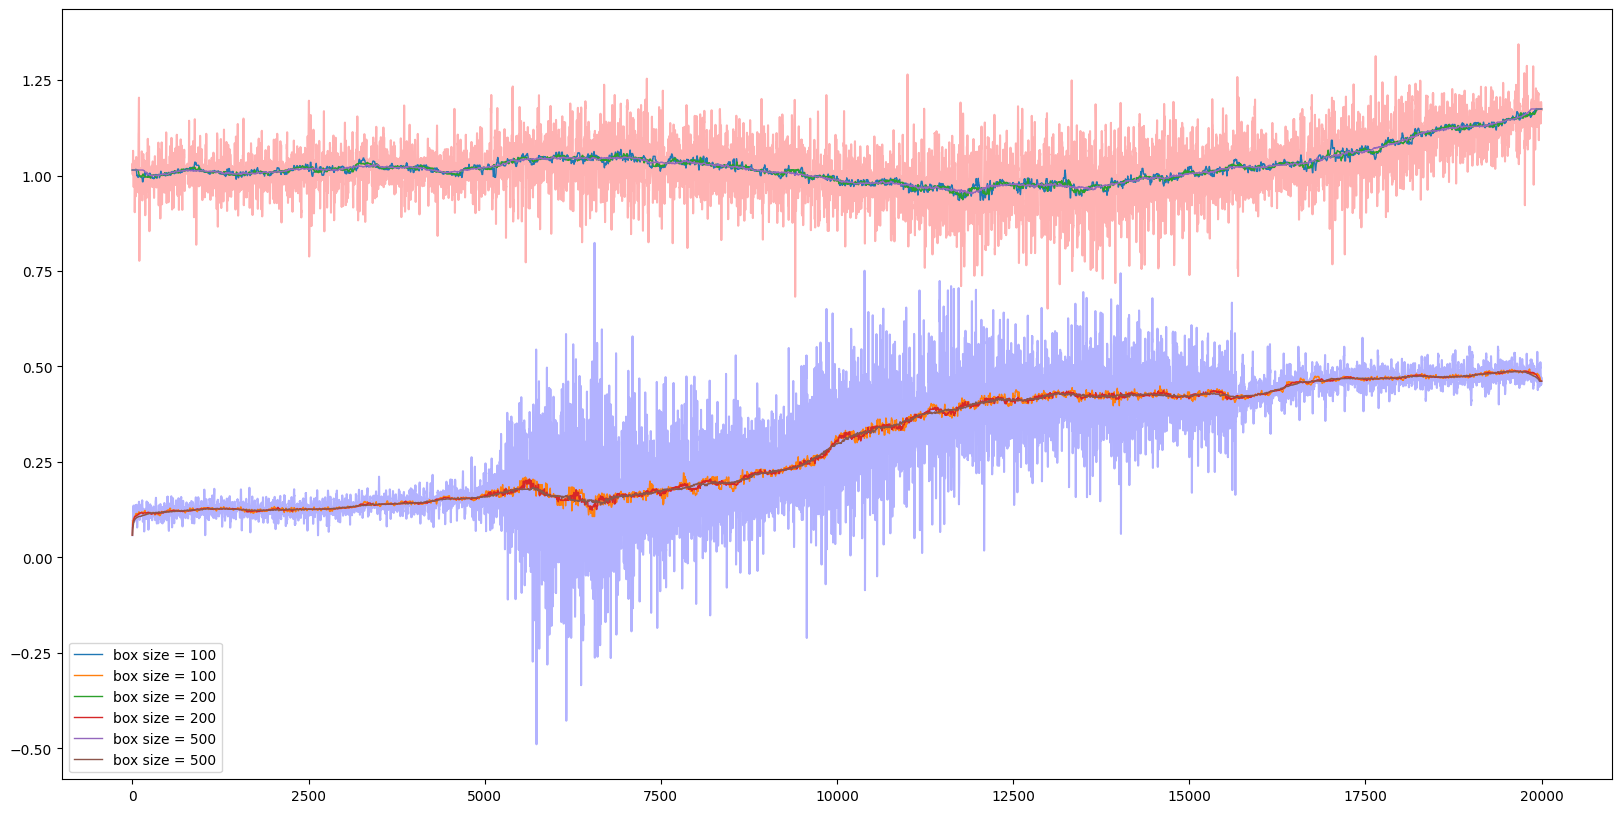

In [18]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(data20_ch2_gestures1['Grip'],c='red',alpha=0.3)
ax.plot(data20_ch3_gestures1['Extension'],c='blue',alpha=0.3)

for bs in [100,200,500]:
    ax.plot(data20_ch2_gestures1.index,median(data20_ch2_gestures1['Grip'],bs),lw=1,label='box size = {}'.format(bs))
    ax.plot(data20_ch3_gestures1.index,median(data20_ch3_gestures1['Extension'],bs),lw=1,label='box size = {}'.format(bs))
    #When the signal is moving with different depths, the median filter does not feature them.
    

ax.legend()
plt.show()

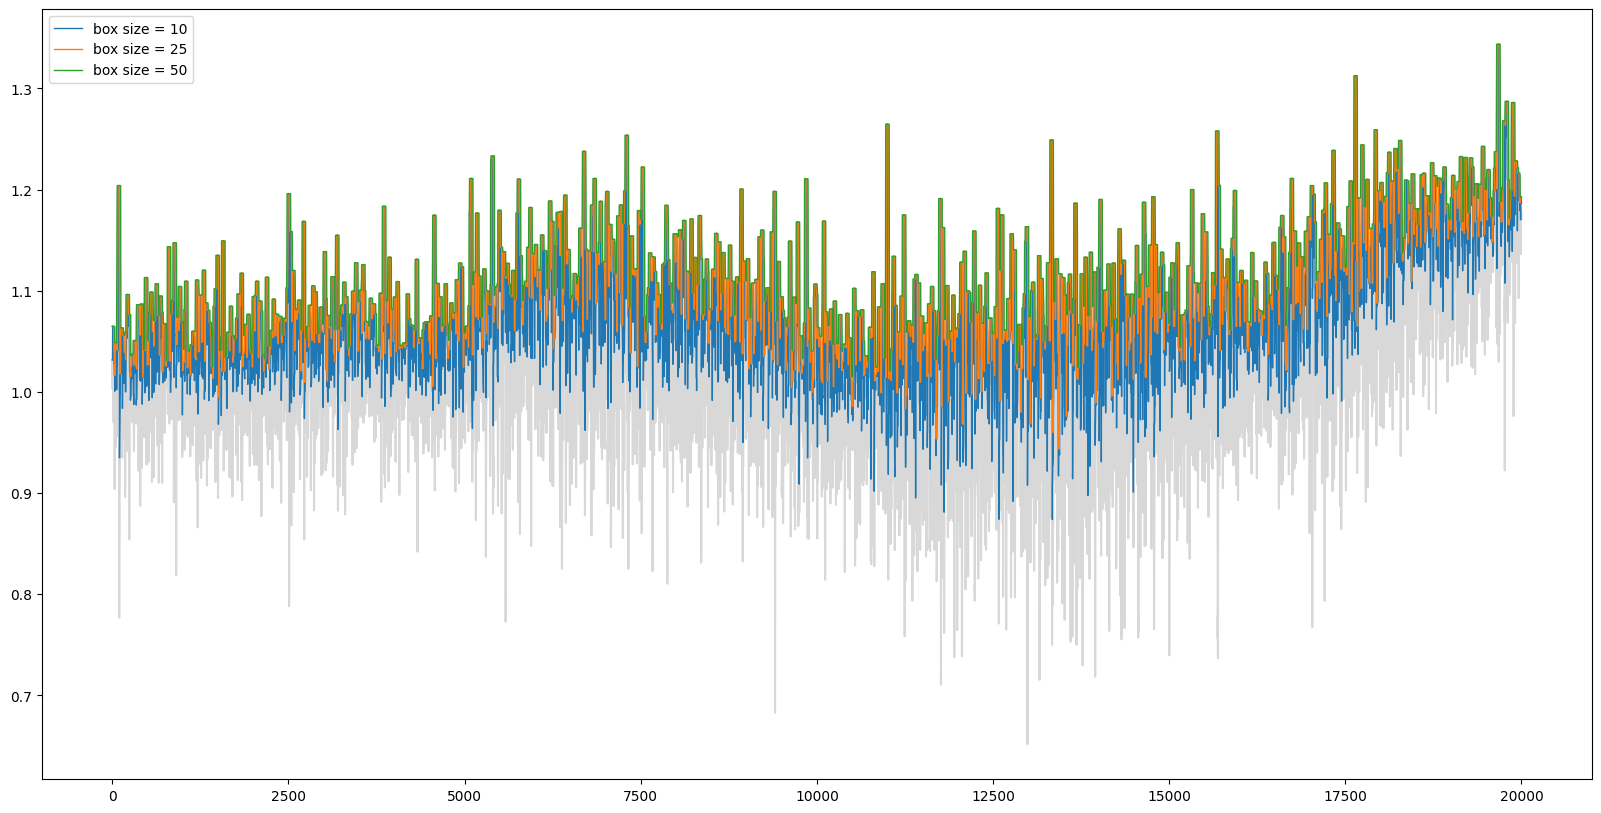

In [5]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(data20_ch2_gestures1['Grip'],c='grey',alpha=0.3)

for bs in [10,25,50]:
    ax.plot(data20_ch2_gestures1.index,maximum(data20_ch2_gestures1['Grip'],bs),lw=1,label='box size = {}'.format(bs)) 
    #Using the maximum filter to find the maximum value of the signal which has characteristics of changing depths.

ax.legend()
plt.show()

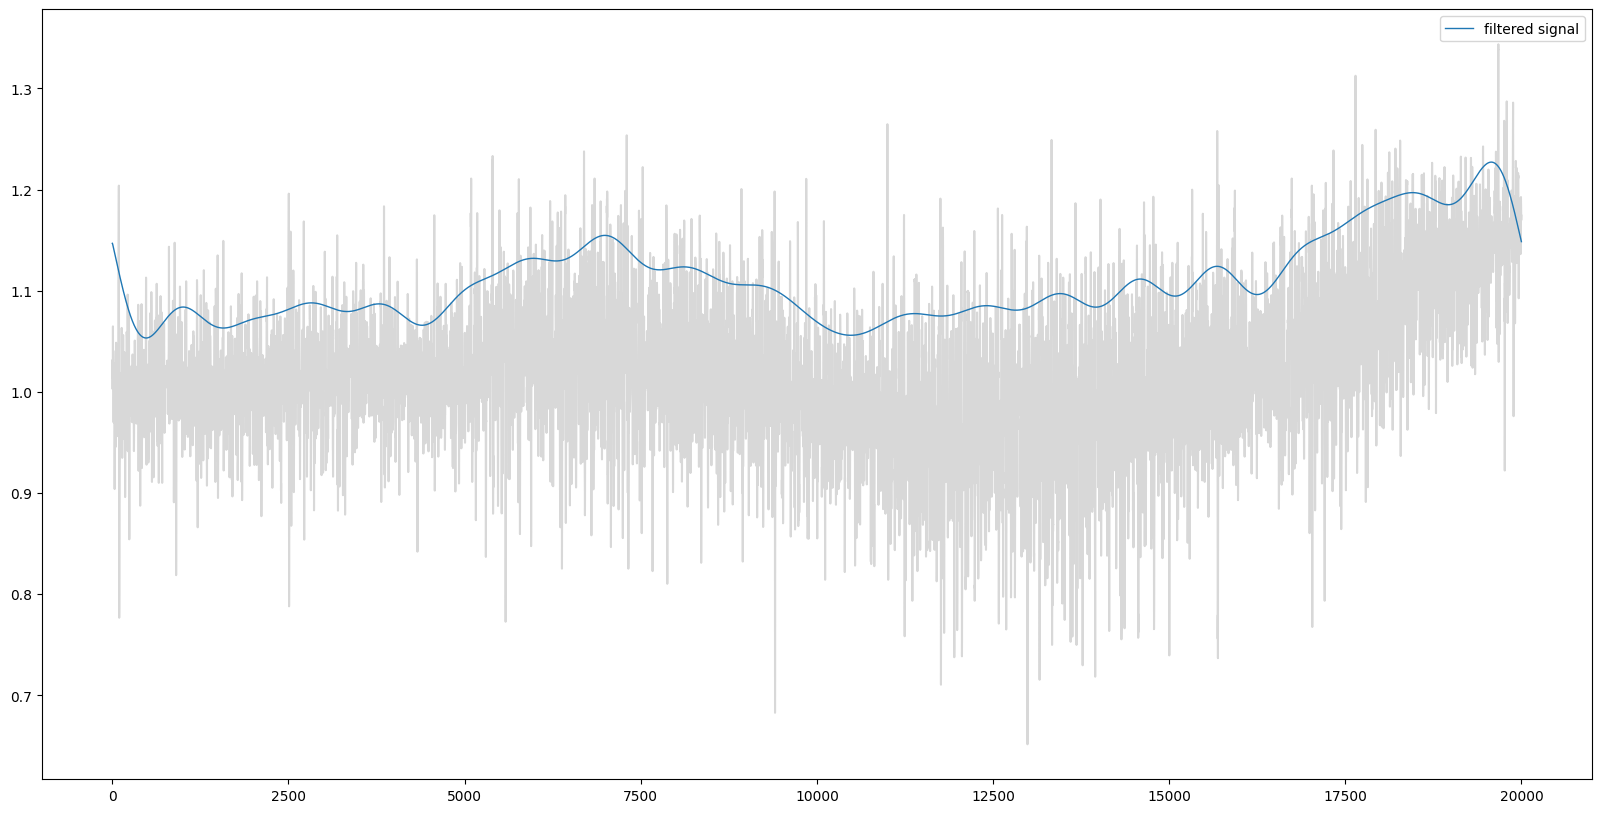

In [20]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(data20_ch2_gestures1['Grip'],c='grey',alpha=0.3)

ax.plot(data20_ch2_gestures1.index,smooth(denoise_fft(maximum(data20_ch2_gestures1['Grip'],25),20),2),lw=1,label='filtered signal') 
#Apply multiple filters (Maximum Filter, Fast Fourier Transformation Denoiser, Kaiser Window Smoothing)
#to make working with shorter signal inputs easier.
#to make the signal smoother and has more elements.

ax.legend()
plt.show()

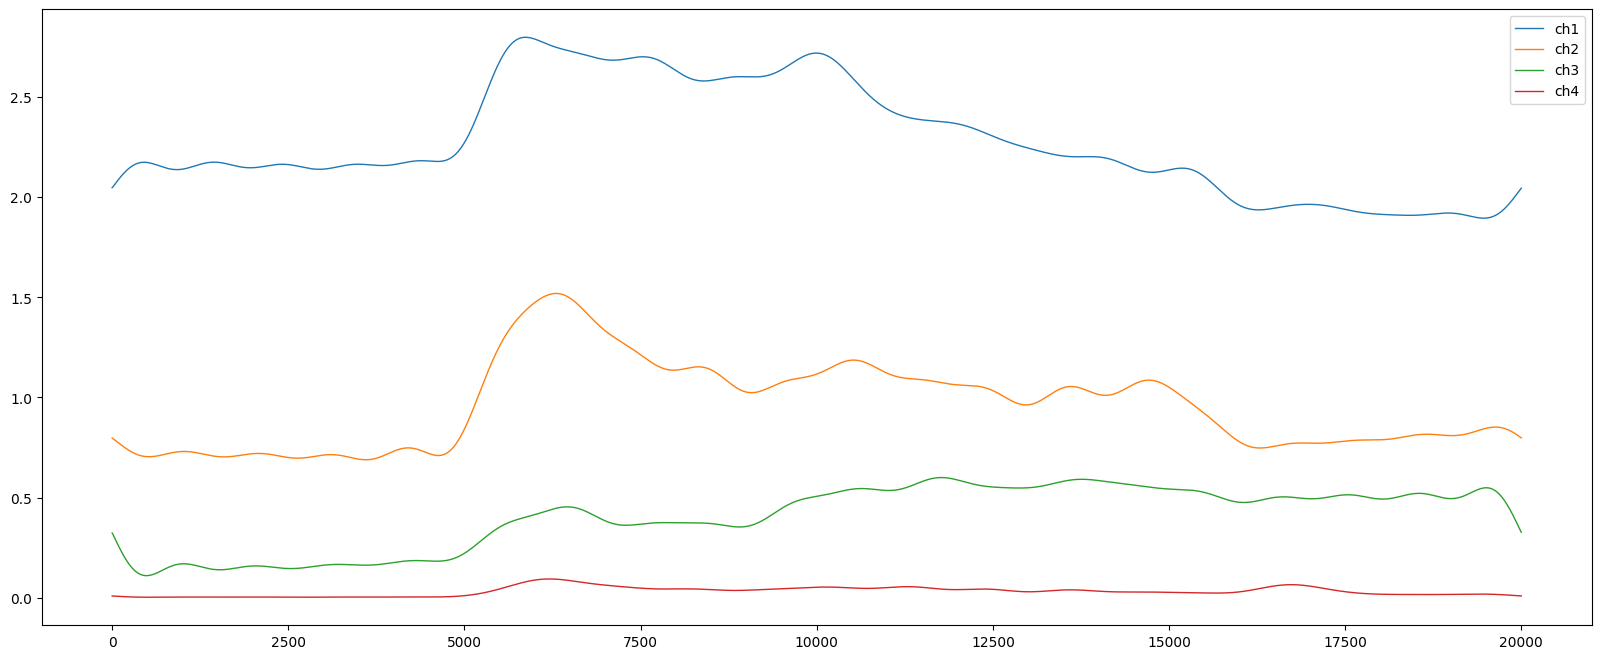

In [7]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)

for i in range(4):
    ax.plot(globals()['data20_ch{}_gestures1'.format(i+1)].index,smooth(denoise_fft(maximum(globals()['data20_ch{}_gestures1'.format(i+1)]['Extension'],25),20),2),lw=1, label='ch{}'.format(i+1))

ax.legend()
plt.show()

The mapped funtions will work when typical gestures are detected.

We need the strongest parts. Especially when the gestures are engaged.

In [8]:
#Make 3-dimensional datas suitable for machine learning. (gesture-channel-time, data_preprocessing.ipynb)

#'Sliding Window' method to get the strongest signal pattern. (after dropping the rest time)

#'Sliding Window Classification' method to classify the gestures on continuous signal input.

In [ ]:
W